In [53]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Level 1: electron density $n_s$ acts as chemical potential

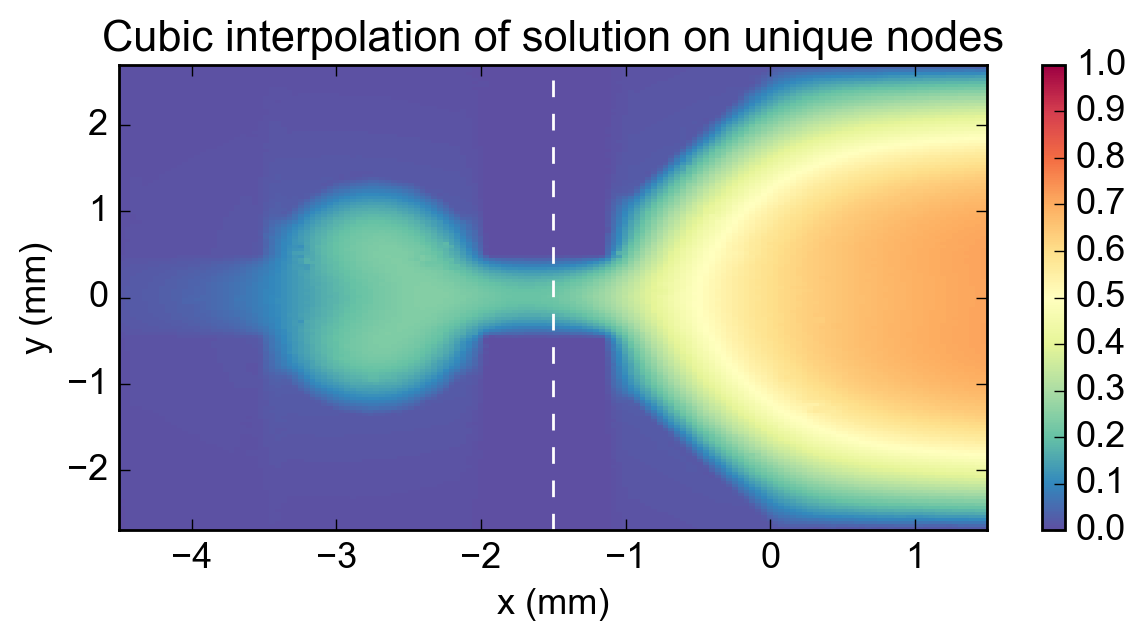

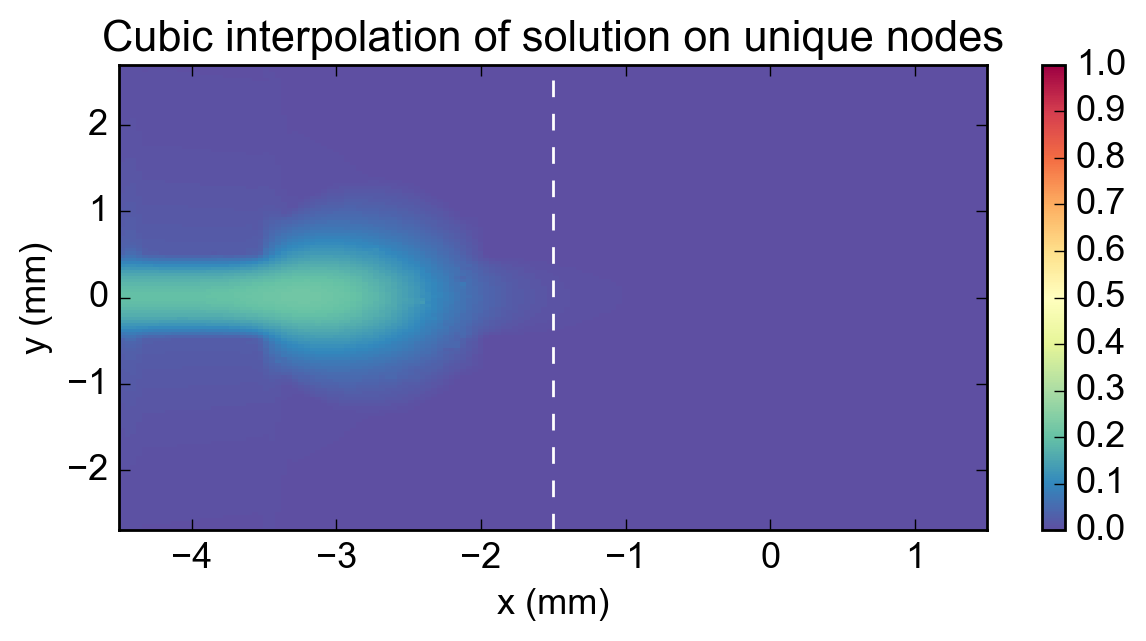

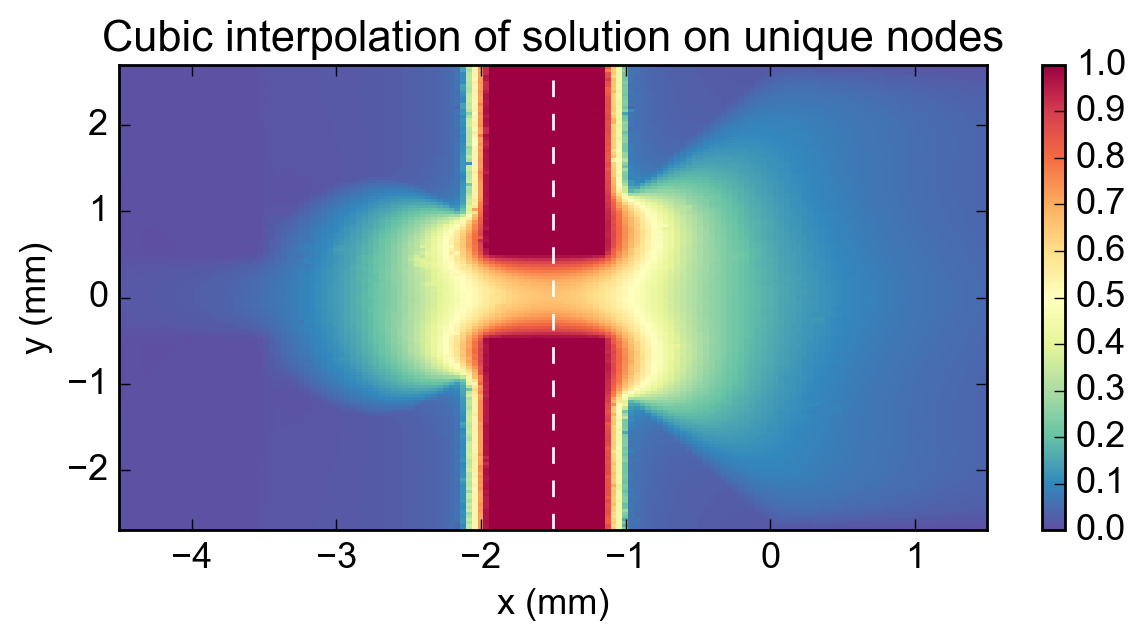

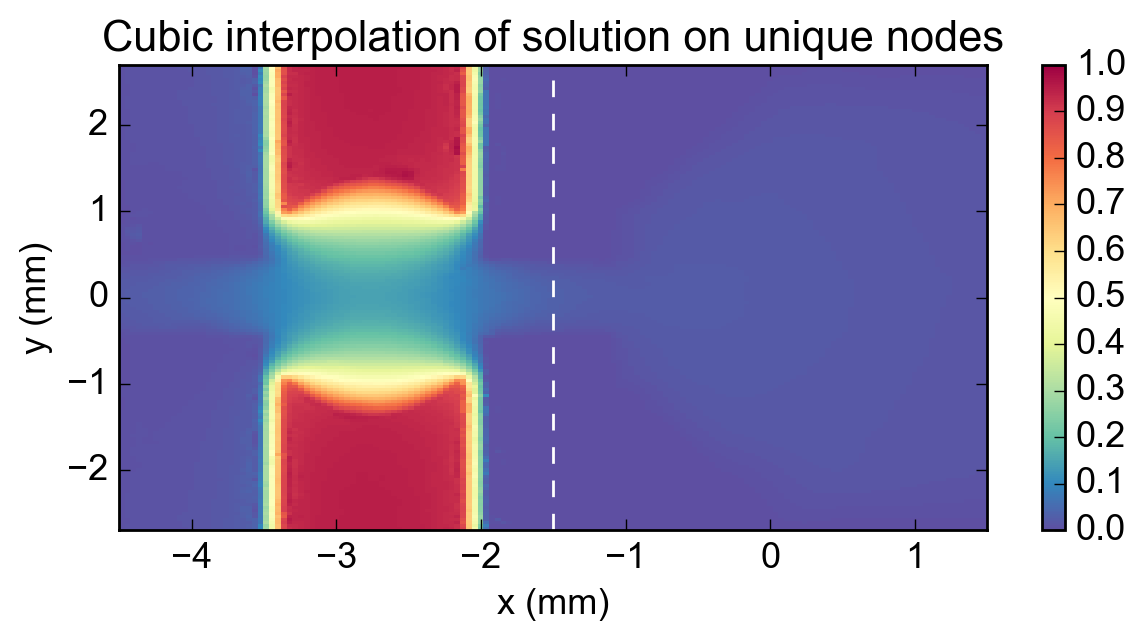

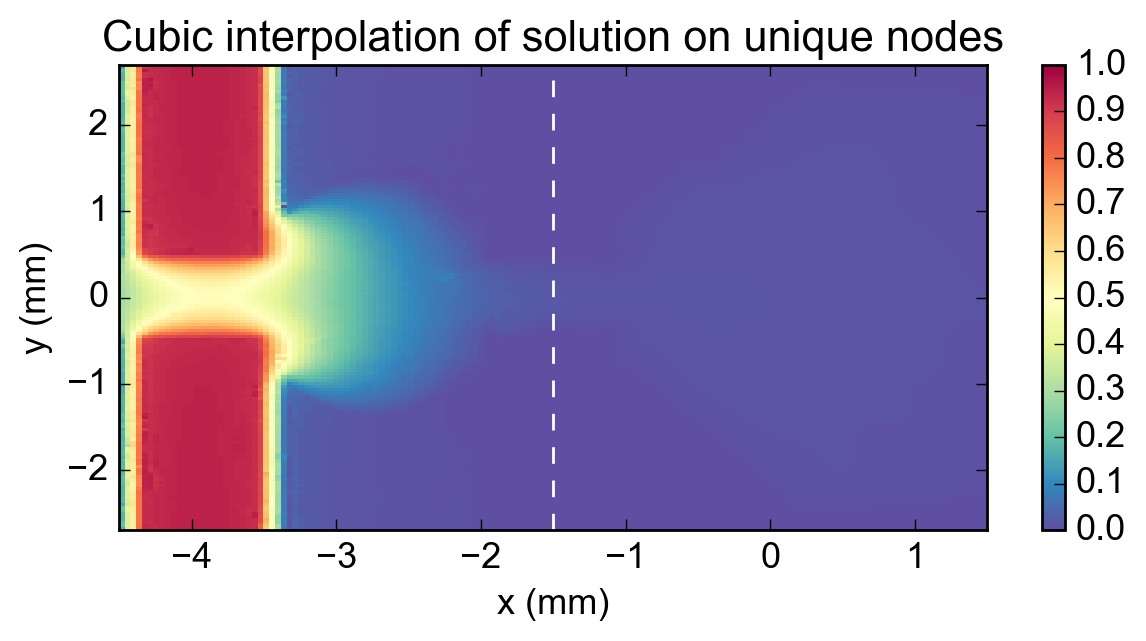

In [138]:
# Evaluate all files in the range
xeval=np.linspace(-4.5, 1.5, 151)
yeval = np.linspace(-2.7, 2.7, 151)

save = True
#save_path = "..\\Maxwell\\M017 Yggdrasil Greater Trap Area\\CutIn 1p5 um"
#save_path = r"/Volumes/dis/Gerwin/Electron on helium/Maxwell/M017 Yggdrasil/Greater Trap Area"
save_path = r"/Users/gkoolstra/Desktop/Where the electrons go"
datafiles = [os.path.join(save_path, "Resonator.dsp"),
             os.path.join(save_path, "Trap.dsp"),
             os.path.join(save_path, "ResonatorGuard.dsp"),
             os.path.join(save_path, "CenterGuard.dsp"), 
             os.path.join(save_path, "TrapGuard.dsp")]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(7.,3.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter
    #interpolate_slow.plot_mesh(os.path.join(datafile))
    xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=(0, 1.0), 
                                                         plot_axes='xy', cmap=plt.cm.Spectral_r, plot_mesh=False)
    output.append({'name' : name, 'V' : np.array(Uinterp.T, dtype=np.float64),
                               'x' : np.array(xinterp.T, dtype=np.float64), 'y' : np.array(yinterp.T, dtype=np.float64)})
    
    plt.vlines(-1.5, np.min(yeval), np.max(yeval), linestyles="--", color="white")

In [90]:
from ipywidgets import FloatSlider, FloatRangeSlider, Checkbox

In [122]:
t = trap_analysis.TrapSolver()
c = trap_analysis.get_constants()
x, y, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
helium_thickness = 0.74E-6

import matplotlib as mpl
common.configure_axes(12)
mpl.rcParams['figure.figsize'] = (7.,3.)

def Visualize(resonator=+0.5, trap=+2.5, resonatorguard=0.0, centerguard=-0.0, trapguard=-0.0, 
              scaling=0.0, colors=0.0, log_electron_density=12.5, 
              resonator_trap_locked=False, left_right_guard_locked=False, 
              auto_scale=False):
    
    fig = plt.figure()
    color_minimum, color_maximum = ColorSlider.value
    
    if resonator_trap_locked:
        trap = resonator
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, resonatorguard, centerguard, trapguard]) * 10**scaling
    combined_potential = t.get_combined_potential(cropped_potentials, coefficients)
    if not auto_scale:
        plt.pcolormesh(x, y, -combined_potential, cmap=plt.cm.Spectral_r, 
                        vmin=color_minimum, vmax=color_maximum)
    else:
        plt.pcolormesh(x, y, -combined_potential, cmap=plt.cm.Spectral_r)
    
    ymin, ymax = np.min(y), np.max(y)
    
    plt.xlabel("x ($\mu$m)")
    plt.ylabel("y ($\mu$m)")
    plt.colorbar()
    plt.xlim(np.min(x), np.max(x))
    plt.ylim(ymin, ymax)
    
    Ve = 10**(log_electron_density) * c['e'] * helium_thickness/(c['eps0'] * 1.056)
    levels = np.array([-np.max(combined_potential[int(len(yeval)/2), -1]) + Ve])
    CS = plt.contour(x, y, -combined_potential, levels, origin='lower', linewidths=2, colors='k', 
                     extent=[np.min(x), np.max(x), ymin, ymax])
    
    biasVoltages = "$V_{res}$ = %.4f\n$V_{trap}$ = %.4f\n$V_{rguard}$ = %.4f\n$V_{cguard}$ = %.4f\n$V_{tguard}$ = %.4f\n$n_s$ = %.2e m$^{-2}$" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, 
     centerguard * 10**scaling, trapguard * 10**scaling, 10**(log_electron_density))
    
    plt.text(3, ymin + 0.2*(ymax-ymin), biasVoltages)
    
ResSlider = FloatSlider(value=1.0, min=-2.0, max=2.0, step=0.05, description='$V_{res}$', 
                       slider_color="#ff6666", )
TrapSlider = FloatSlider(value=1.0, min=-2.0, max=2.0, step=0.05, description='$V_{trap}$', 
                       slider_color="#ff6666")
RGSlider = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.05, description='$V_{rguard}$', 
                       slider_color="#3366ff")
CGSlider = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.05, description='$V_{cguard}$', 
                       slider_color="#3366ff")
TGSlider = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.05, description='$V_{tguard}$', 
                       slider_color="#3366ff")
nsSlider = FloatSlider(value=0.0, min=12, max=13, step=0.05, description='$^{10}$log($n_s$)')
ColorSlider = FloatRangeSlider(value=(-0.5, 0), min=-0.5, max=0.5, step=0.05, description="Colorbar")
AutoScaleBox = Checkbox(value=False, description="Auto scale?")
LockGuards = Checkbox(value=False, description="Lock guards")
LockResTrap = Checkbox(value=False, description="Lock res & trap")


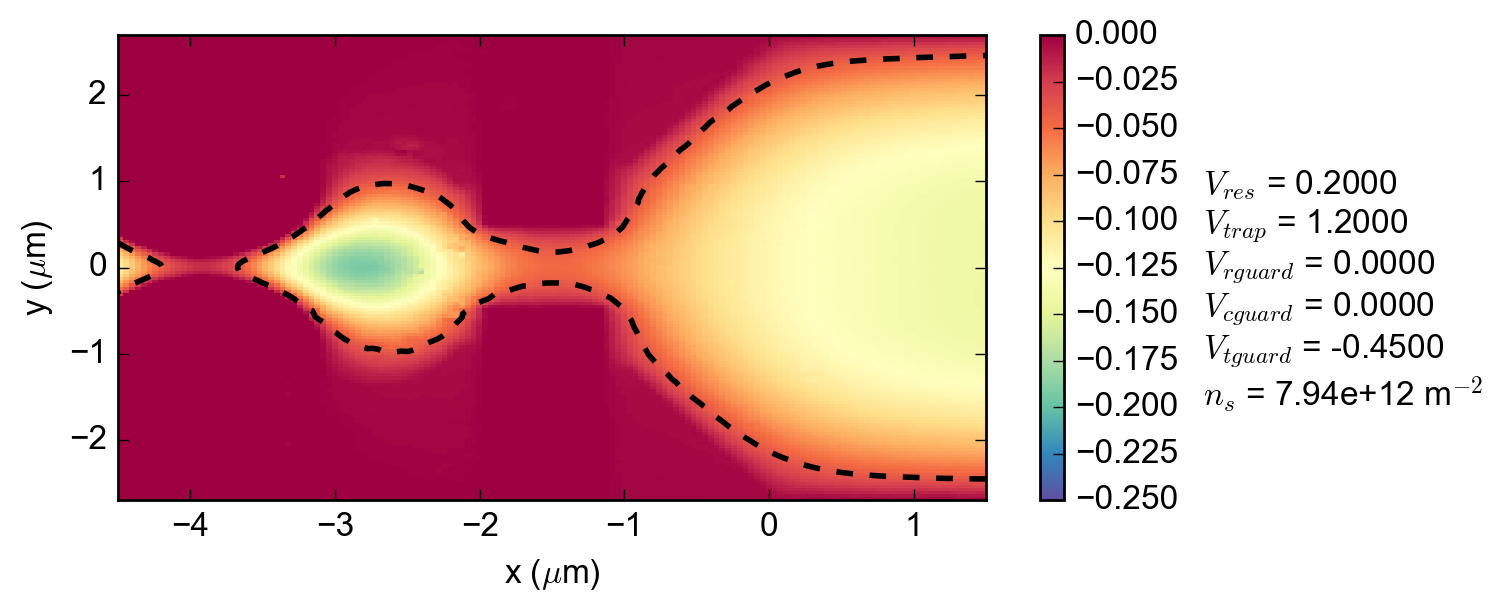

In [123]:
#interact_manual(Visualize, resonator=ResSlider, trap=TrapSlider, 
#                resonatorguard=RGSlider, centerguard=CGSlider, trapguard=TGSlider, scaling=(-2.0, 1.0, 0.01),
#                colors=ColorSlider, log_electron_density=nsSlider, 
#                resonator_trap_locked=LockResTrap, left_right_guard_locked=LockGuards, 
#                auto_scale=AutoScaleBox);

interact(Visualize, resonator=ResSlider, trap=TrapSlider, 
         resonatorguard=RGSlider, centerguard=CGSlider, trapguard=TGSlider, scaling=(-2.0, 1.0, 0.01),
         colors=ColorSlider, log_electron_density=nsSlider, 
         resonator_trap_locked=LockResTrap, left_right_guard_locked=LockGuards, 
         auto_scale=AutoScaleBox, continuous_update=False);

# Example of combined potential landscape 

In [104]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

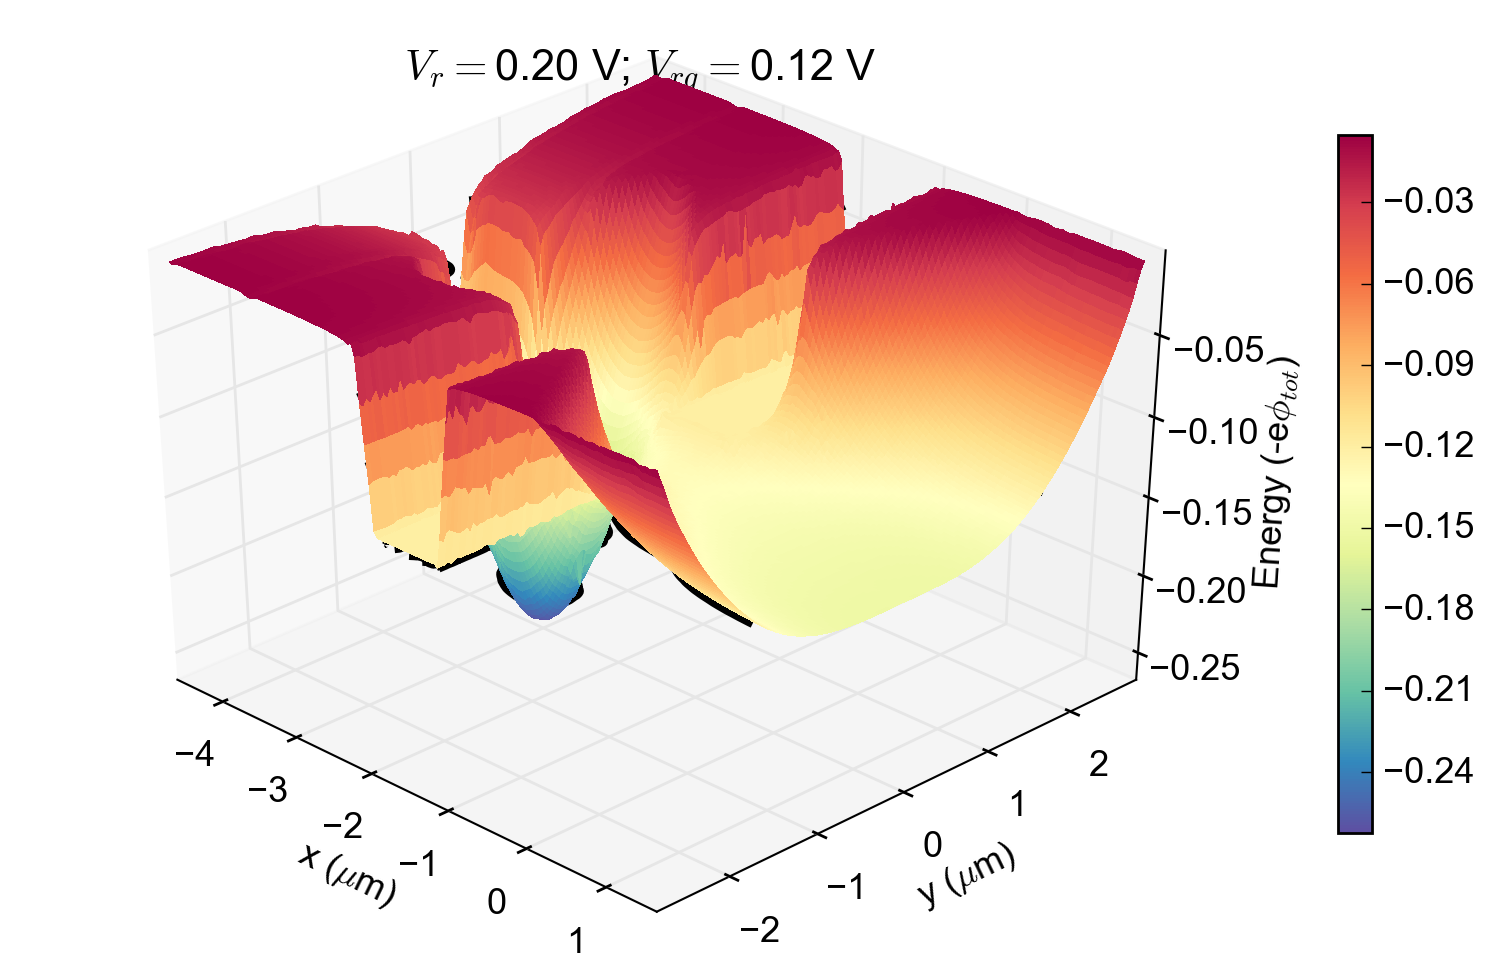

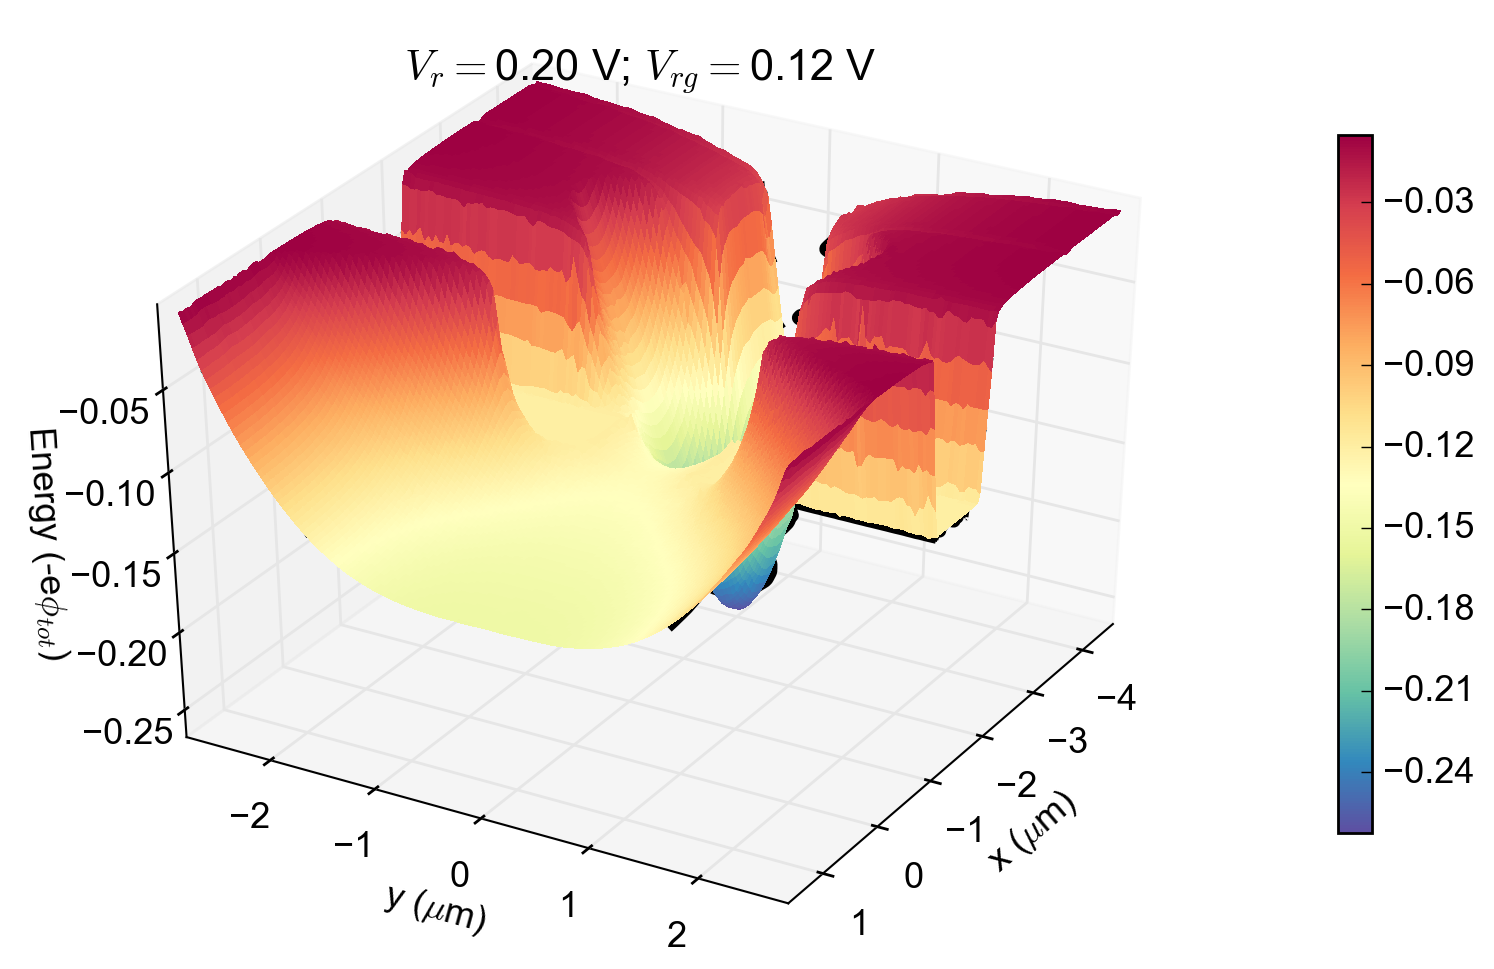

In [137]:
Xm, Ym = np.meshgrid(xeval, yeval)
Vr = output[0]['V']
Vt = output[1]['V']
Vrg = output[2]['V']

# These are the actual voltages you put on the electrodes
Vr_coef = 0.20
Vrg_coef = 0.12
Vt_coef = 1.00

Zm = Vr_coef * Vr + Vrg_coef * Vrg + Vt_coef * Vt

for view_angle in [-45, 30]:
    fig = plt.figure(figsize=(10.,6.))
    common.configure_axes(13)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(Xm, Ym, -Zm.T, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                           linewidth=0, antialiased=False)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_zlabel("Energy (-e$\phi_{tot}$)")
    ax.view_init(elev=35., azim=view_angle)
    fig.colorbar(surf, shrink=0.75, aspect=20)
    plt.title("$V_r = $%.2f V; $V_{rg} = $%.2f V"%(Vr_coef, Vrg_coef))
    
    #common.save_figure(fig, save_path=save_path)

(-4.5, 1.5)

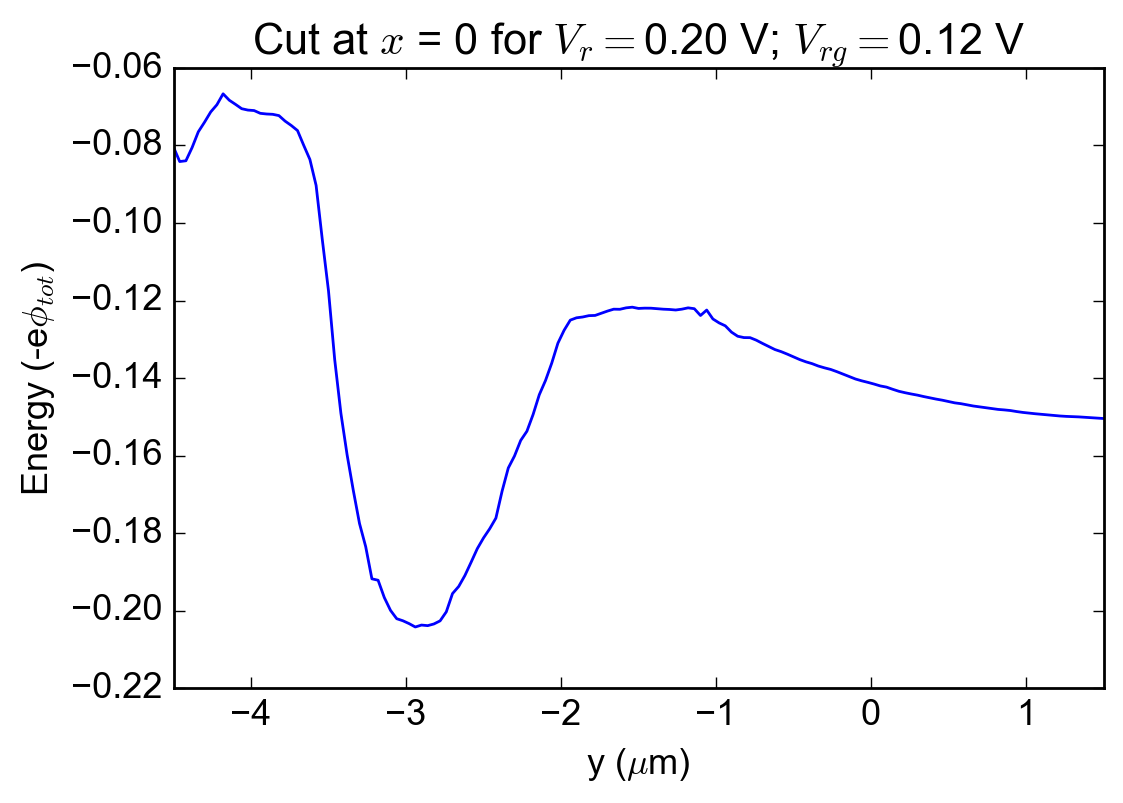

In [117]:
yoi = -0.0
yoi_idx = common.find_nearest(yeval, yoi)

plt.figure(figsize=(6.,4.))
plt.plot(Xm[yoi_idx, :], -Zm[:, xoi_idx])
plt.xlabel("x ($\mu$m)")
plt.ylabel("Energy (-e$\phi_{tot}$)")
plt.title("Cut at $y$ = 0 for $V_r = $%.2f V; $V_{rg} = $%.2f V"%(Vr_coef, Vrg_coef))
plt.xlim(np.min(xeval), np.max(xeval))

#if save: 
#    common.save_figure(fig, save_path=save_path)